In [1]:
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
from bellem.dvc.experiment import load_experiments

filenames = [
    "hotpotqa-train.json",
]

experiments = [exp for filename in filenames for exp in load_experiments(filename)]
print(f"{len(experiments)} experiments")
experiments[0]

22 experiments


{'commit': 'workspace',
 'id': 'workspace',
 'name': None,
 'params': {'train': {'dataset': {'path': 'bdsaglam/musique-mini',
    'name': 'answerable',
    'split': 'train'},
   'optimizer': 'noop'},
  'evaluation': {'dataset': {'path': 'bdsaglam/musique',
    'name': 'answerable',
    'split': 'validation'}},
  'qa': {'model': 'llama-3-70b-tgi',
   'temperature': 0.1,
   'technique': 'standard'},
  'run': 1},
 'metrics': {}}

In [3]:
df = pd.json_normalize(experiments).drop(columns=["commit", "id"])
df = df[df["params.evaluation.dataset.path"] == "bdsaglam/hotpotqa-distractor"].copy()
df.drop(columns=[col for col in df.columns if 'fuzzy' in col], inplace=True)

param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.dropna(subset=param_cols + metric_cols, inplace=True, how="any")
df.drop_duplicates(subset=param_cols, inplace=True)
df

,name,params.train.dataset.path,params.train.dataset.name,params.train.dataset.split,params.train.optimizer,params.evaluation.dataset.path,params.evaluation.dataset.name,params.evaluation.dataset.split,params.qa.model,params.qa.temperature,...,metrics.6hops.exact_match,metrics.6hops.f1,metrics.12hops.exact_match,metrics.12hops.f1,metrics.9hops.exact_match,metrics.9hops.f1,metrics.8hops.exact_match,metrics.8hops.f1,metrics.11hops.exact_match,metrics.11hops.f1
5,huger-pomp,bdsaglam/hotpotqa-distractor-mini,default,validation,bfsrs-medium,bdsaglam/hotpotqa-distractor,default,train,llama-3-70b-tgi,0.1,...,0.687943,0.821776,1.0,1.0,1.0,1.0,0.941176,0.988235,1.0,1.0
6,aulic-cart,bdsaglam/hotpotqa-distractor-mini,default,validation,bfsrs-medium,bdsaglam/hotpotqa-distractor,default,train,llama-3-70b-tgi,0.1,...,0.744681,0.848160,1.0,1.0,1.0,1.0,0.882353,0.978431,1.0,1.0
7,tonic-moxa,bdsaglam/hotpotqa-distractor-mini,default,validation,noop,bdsaglam/hotpotqa-distractor,default,train,llama-3-70b-tgi,0.1,...,0.723404,0.855549,0.0,0.4,1.0,1.0,0.882353,0.978431,1.0,1.0
8,mixed-zhos,bdsaglam/hotpotqa-distractor-mini,default,validation,bfsrs-medium,bdsaglam/hotpotqa-distractor,default,train,llama-3-70b-tgi,0.1,...,0.709220,0.827271,1.0,1.0,1.0,1.0,0.882353,0.978431,1.0,1.0
9,sport-sign,bdsaglam/hotpotqa-distractor-mini,default,validation,noop,bdsaglam/hotpotqa-distractor,default,train,llama-3-70b-tgi,0.1,...,0.716312,0.851171,0.0,0.0,1.0,1.0,0.941176,0.988235,1.0,1.0


In [4]:
target_params = ["params.qa.technique", "params.train.optimizer", "params.qa.temperature"]

In [5]:
run_counts = df.groupby(target_params)[metric_cols[:1]].count().reset_index()
mask = run_counts[metric_cols[0]] < 3
run_counts.loc[mask]

,params.qa.technique,params.train.optimizer,params.qa.temperature,metrics.exact_match
0,cot,bfsrs-medium,0.1,1
1,cot,noop,0.1,1
2,cte,bfsrs-medium,0.1,1
3,standard,bfsrs-medium,0.1,1
4,standard,noop,0.1,1


In [6]:
df.sort_values(by='metrics.f1', ascending=False)[['name'] + target_params + ['metrics.f1']].head(10)

,name,params.qa.technique,params.train.optimizer,params.qa.temperature,metrics.f1
6,aulic-cart,cot,bfsrs-medium,0.1,0.893326
8,mixed-zhos,standard,bfsrs-medium,0.1,0.891397
5,huger-pomp,cte,bfsrs-medium,0.1,0.887032
7,tonic-moxa,cot,noop,0.1,0.875069
9,sport-sign,standard,noop,0.1,0.868249


In [7]:
# Aggregate metrics over repeated runs (params.run)
df_target = df.groupby(target_params)[metric_cols].max().reset_index()
df_target[[*target_params, *metric_cols[:2]]].sort_values("metrics.f1")

,params.qa.technique,params.train.optimizer,params.qa.temperature,metrics.exact_match,metrics.f1
4,standard,noop,0.1,0.767742,0.868249
1,cot,noop,0.1,0.780479,0.875069
2,cte,bfsrs-medium,0.1,0.801331,0.887032
3,standard,bfsrs-medium,0.1,0.810021,0.891397
0,cot,bfsrs-medium,0.1,0.811989,0.893326


In [8]:
df_target = df_target.copy()
df_target.sort_values('metrics.f1', inplace=True)

,params.qa.technique,params.train.optimizer,params.qa.temperature,metrics.exact_match,metrics.f1
0,cot,bfsrs-medium,0.100,0.812,0.893
3,standard,bfsrs-medium,0.100,0.810,0.891
2,cte,bfsrs-medium,0.100,0.801,0.887


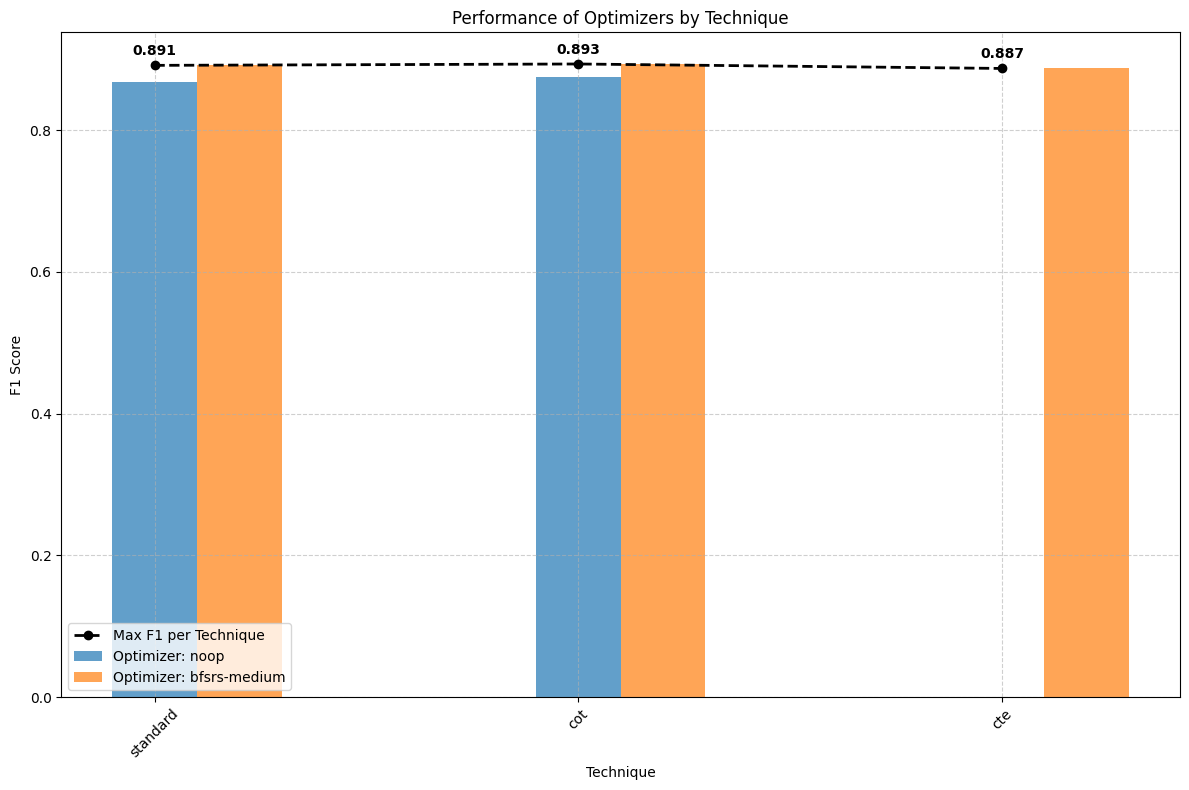

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import display

# Group by technique and find the best optimizer for each technique
best_per_technique = df_target.loc[df_target.groupby("params.qa.technique")["metrics.f1"].idxmax(), target_params + metric_cols[:2]]

# Sort techniques by best F1 score
best_per_technique = best_per_technique.sort_values(by="metrics.f1", ascending=False)

# Highlight the maximum F1 score in bold using Styler and format to 3 decimal places
styled_df = best_per_technique.style.highlight_max(subset=["metrics.f1"], props="font-weight: bold;").format(precision=3)

# Display the best optimizers per technique as a styled DataFrame
display(styled_df)

# Bar and Line Plot for Techniques and Optimizers
techniques = df_target["params.qa.technique"].unique()
optimizers = df_target["params.train.optimizer"].unique()

fig, ax = plt.subplots(figsize=(12, 8))
width = 0.2  # Bar width
x = np.arange(len(techniques))  # X positions for techniques

# Prepare data for plotting
bar_offsets = {optimizer: idx - len(optimizers) // 2 for idx, optimizer in enumerate(range(len(optimizers)))}

# Plot bars for each optimizer
for idx, optimizer in enumerate(optimizers):
    optimizer_f1 = [
        df_target[(df_target["params.qa.technique"] == technique) & (df_target["params.train.optimizer"] == optimizer)]["metrics.f1"].max()
        for technique in techniques
    ]
    ax.bar(x + width * idx, optimizer_f1, width, label=f"Optimizer: {optimizer}", alpha=0.7)

# Plot line for maximum F1 per technique
max_f1_per_technique = [df_target[df_target["params.qa.technique"] == technique]["metrics.f1"].max() for technique in techniques]
ax.plot(x, max_f1_per_technique, label="Max F1 per Technique", color="black", linestyle="--", marker="o", linewidth=2)

# Annotate the maximum F1 line
for i, f1_value in enumerate(max_f1_per_technique):
    ax.text(x[i], f1_value + 0.01, f"{f1_value:.3f}", ha="center", va="bottom", fontsize=10, fontweight="bold")

# Add legend and titles
ax.set_title("Performance of Optimizers by Technique")
ax.set_xlabel("Technique")
ax.set_ylabel("F1 Score")
ax.set_xticks(x)
ax.set_xticklabels(techniques, rotation=45)
ax.legend()
ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

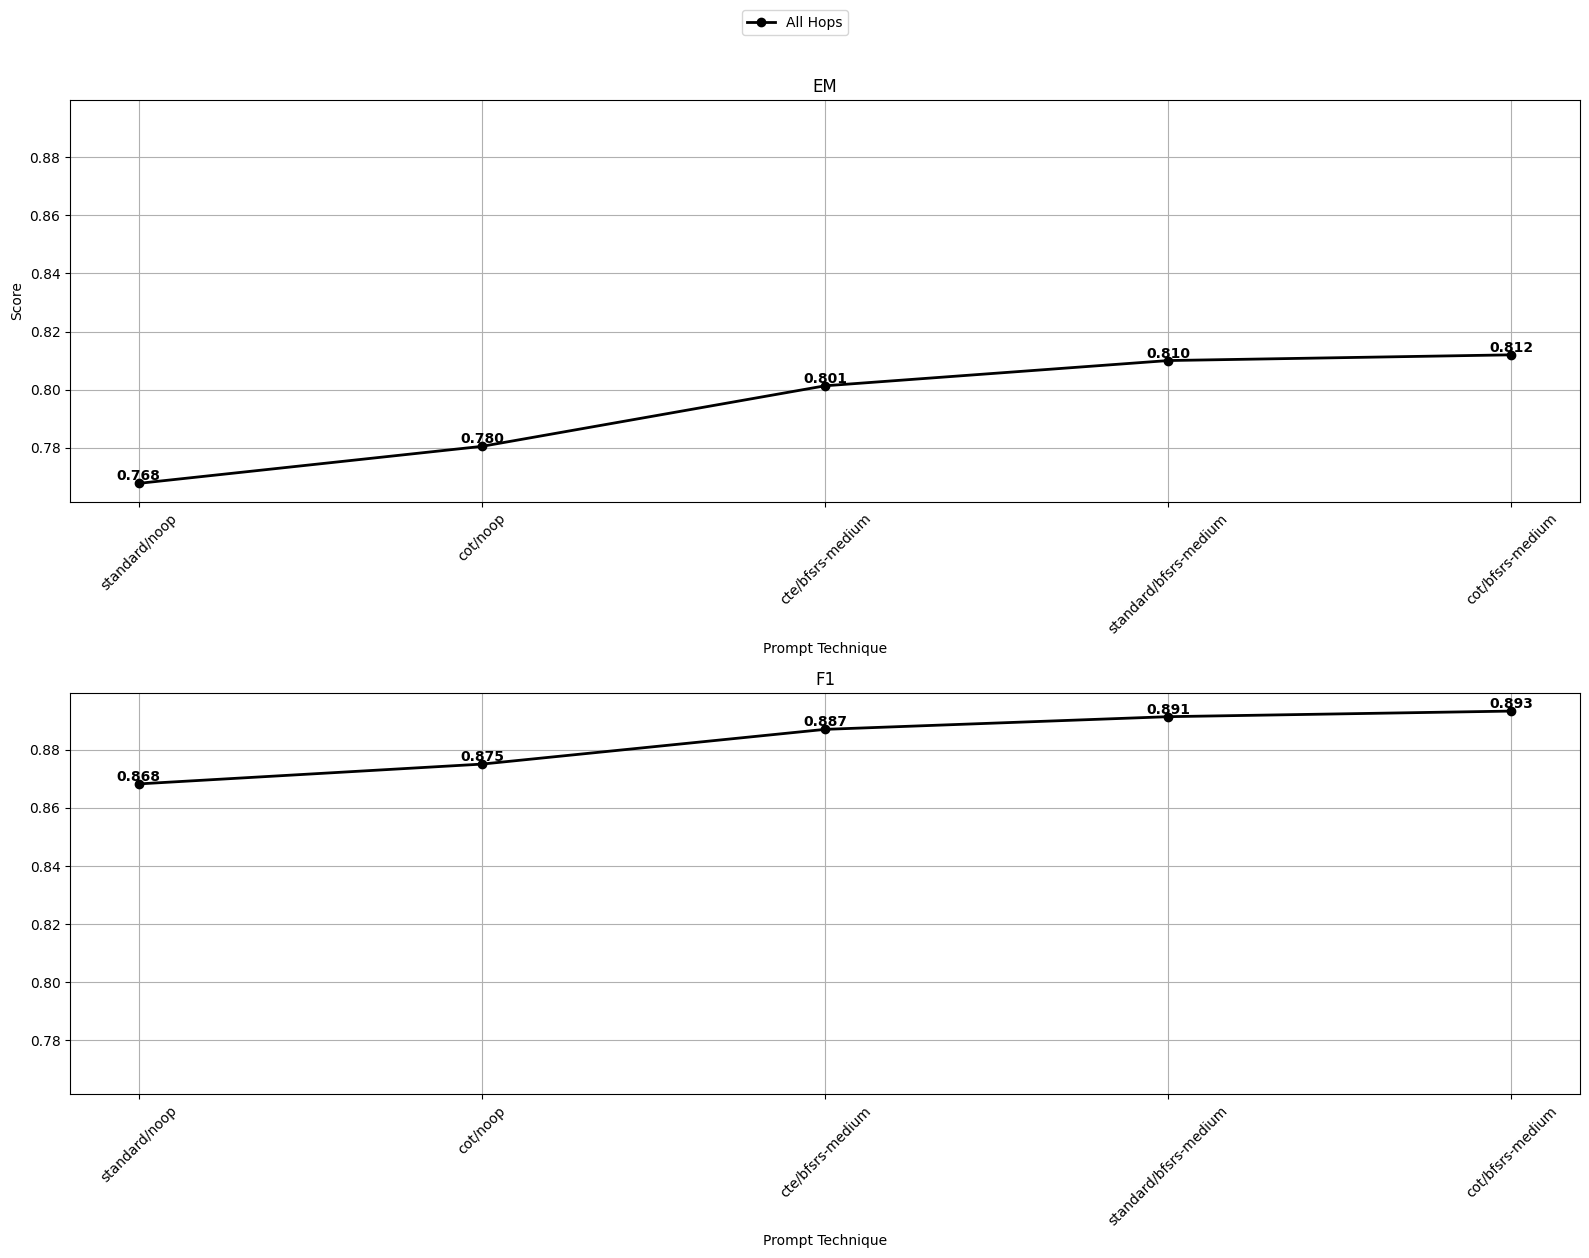

In [10]:
def plot_metric(ax, x, width, prompts, metrics, title, ylabel=None):
    # Plotting all hops as a line plot
    ax.plot(x, metrics["all"], label="All Hops", color="k", linestyle="-", marker="o", linewidth=2)

    # Adding values on top of the line plot
    for i, value in enumerate(metrics["all"]):
        ax.text(
            x[i],
            value,
            f"{value:.3f}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    # Adjust titles and labels
    ax.set_title(title)
    ax.set_xlabel("Prompt Technique")
    ax.set_xticks(x)
    ax.set_xticklabels([prompt.replace(".txt", "") for prompt in prompts], rotation=45)
    if ylabel:
        ax.set_ylabel(ylabel)
    ax.grid(True)


# Creating subplots for Exact Match and F1, separating them for clarity
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharey=True)

width = 0.3  # Bar width adjustment

prompts = [
    f"{pt}/{optim}"
    for pt, optim in zip(df_target["params.qa.technique"].values, df_target["params.train.optimizer"].values)
]
x = np.arange(len(prompts))


# Plotting Exact Match
metrics_em = {
    "all": df_target["metrics.exact_match"].values,
}
plot_metric(ax1, x, width, prompts, metrics_em, title="EM", ylabel="Score")

# Plotting F1
metrics_f1 = {
    "all": df_target["metrics.f1"].values,
}
plot_metric(ax2, x, width, prompts, metrics_f1, title="F1")

# Creating a shared legend outside the plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4)

plt.tight_layout()
plt.show()